In [1]:
import os
import cv2
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
import pandas as pd
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split, cross_val_score, KFold  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score  

In [2]:
df = pd.read_csv('titanic.csv')

(array([124.,  53.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

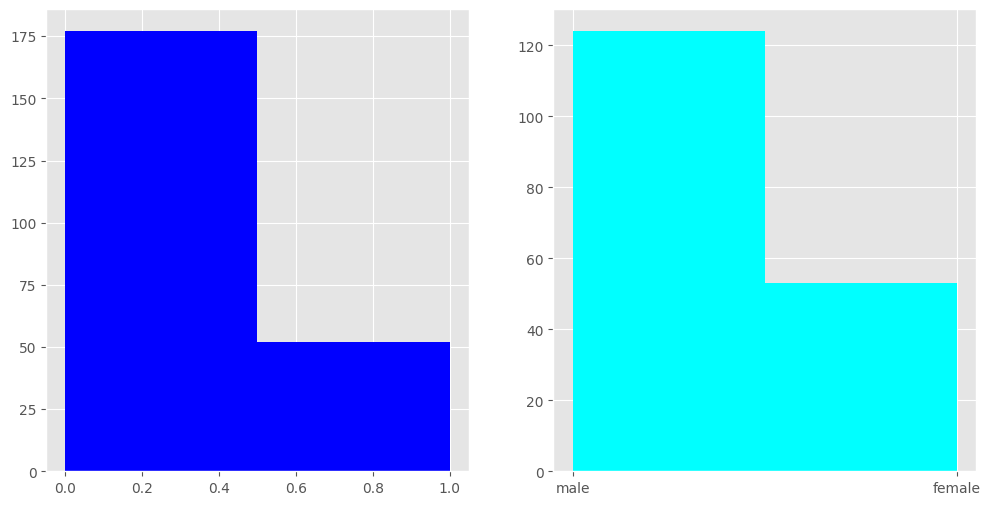

In [3]:
noage = df.loc[(pd.isna(df['Age']))]
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(noage.Survived, bins=2, cumulative=-1, color='blue')
ax[1].hist(noage.Sex, bins=2, color='aqua')

In [4]:
# Создам переменную содержащую перечень титулов
titles = ('Capt.', 'Col.', 'Major.', 'Sir.', 'Lady.', 'Rev.', 'Dr.', 'Don.', 'Jonkheer.', 
        'Countess.', 'Mrs.', 'Ms.', 'Mr.', 'Mme.', 'Mlle.', 'Miss.', 'Master.')

# Создам список титулов для каждого пассажира
title_names = []
for name in df.Name:
    for title in titles:
        if title in name.split(' '):
            title_names.append(title)
            break

# Добавлю в датафрейм новый столбец - Титул
df.insert(12, 'Title', title_names)

# Создам словарь с парами "титул: список возрастов"
ages = dict.fromkeys(titles, [])
for i, title in enumerate(df.Title):
    if not pd.isna(df.Age[i]):
        ages[title] = ages[title] + [df.Age[i]]

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\1742592721.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ages.values(), labels=titles, vert=True)


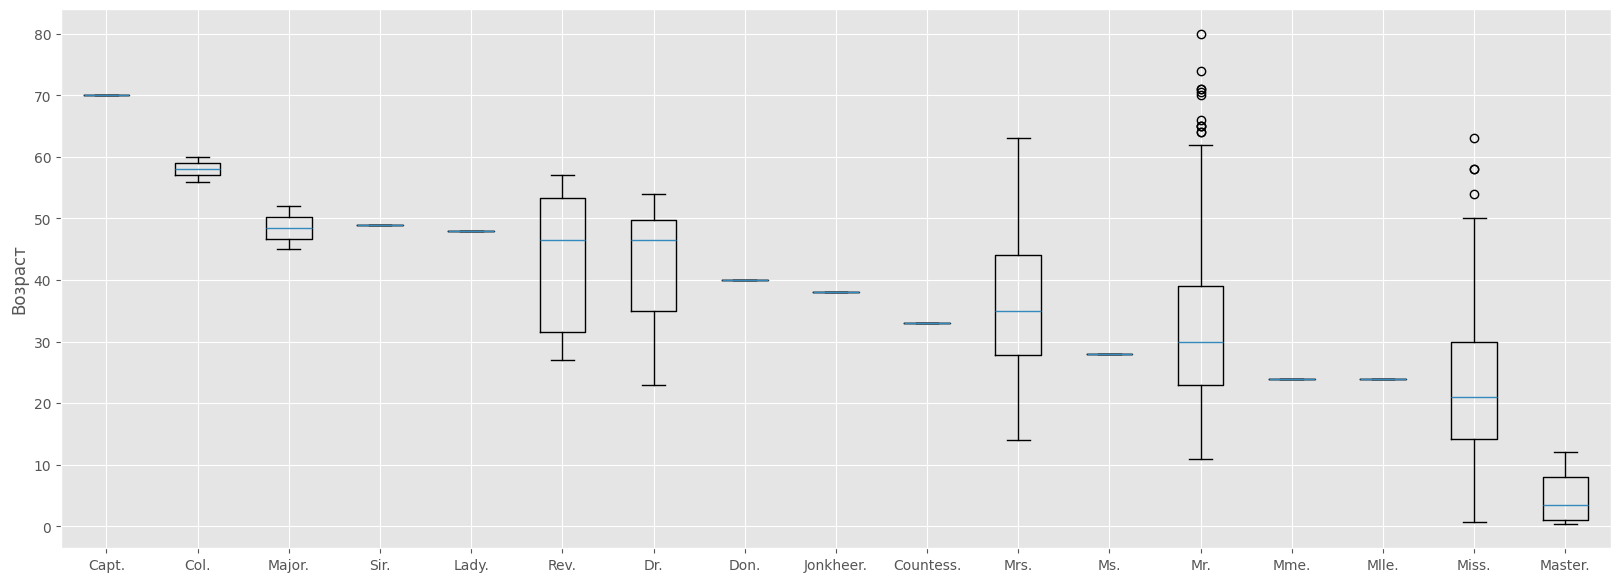

In [5]:
#Визуализирую 
fig, ax = plt.subplots(figsize=(20,7))
ax.boxplot(ages.values(), labels=titles, vert=True)
ax.set_ylabel('Возраст')
plt.show()

In [6]:
for i, age in enumerate(df.Age):
    if pd.isna(age):
        df.Age[i] = np.median(ages[df.Title[i]])

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\465514871.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[i] = np.median(ages[df.Title[i]])
C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\465514871.py:3: 

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\1893162924.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Title[i] = 'Aristocratic.'
C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\1893162924.py:10: Setting

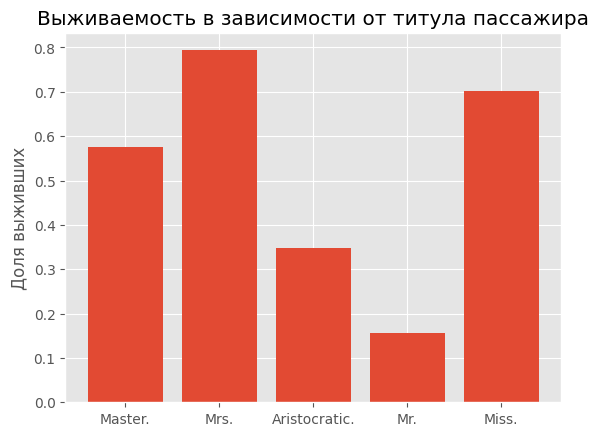

In [7]:
# Группы для объединения
aristocratic = ('Capt.', 'Col.', 'Don.', 'Dr.', 'Jonkheer.', 'Lady.', 'Major.',
               'Rev.', 'Sir.', 'Countess.')
mrs = ('Ms.', 'Mrs')
miss = ('Mlle.', 'Mme.')

# Объединяю титулы
for i, title in enumerate(df.Title):
    if title in aristocratic:
        df.Title[i] = 'Aristocratic.'
    elif title in miss:
        df.Title[i] = 'Miss.'
    elif title in mrs:
        df.Title[i] = 'Mrs.'

# Посмотри на долю выживших, так как количество людей в каждом из титулов значительно разниться
title_survive_percent = dict.fromkeys(set(df.Title), None)
for title in title_survive_percent.keys():
    title_survive_percent[title] = len(df.loc[((df['Title'] == title)
        & (df['Survived'] == 1))]) / len(df.loc[(df['Title'] == title)])

# Визуализирую 
fix, ax = plt.subplots()
ax.bar(title_survive_percent.keys(), title_survive_percent.values())
ax.set_ylabel('Доля выживших')
ax.set_title('Выживаемость в зависимости от титула пассажира')
plt.show()

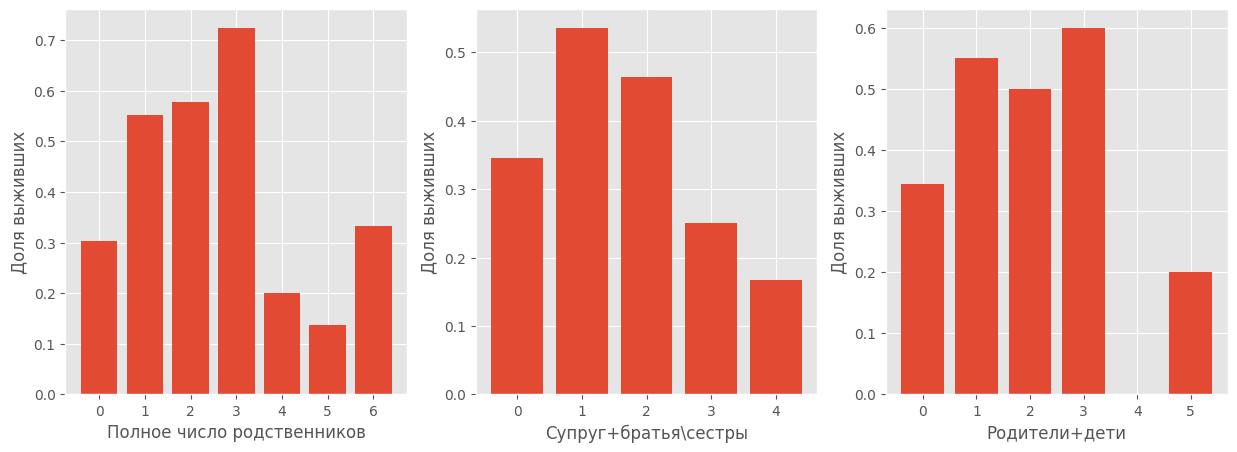

In [43]:
# Добавим признак family
#df.insert(13, 'Family', np.array(df.SibSp, int) + np.array(df.Parch, int))


sibsp_total = dict(Counter(df.SibSp))
parch_total = dict(Counter(df.Parch))
family_total = dict(Counter(df.Family))
sibsp_survived = dict(Counter(df.loc[(df['Survived'] == 1)].SibSp))
parch_survived = dict(Counter(df.loc[(df['Survived'] == 1)].Parch))
family_survived = dict(Counter(df.loc[(df['Survived'] == 1)].Family))
relatives = (family_total, sibsp_total, parch_total)
relatives_survived = (family_survived, sibsp_survived, parch_survived)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
xlabs = ('Полное число родственников', 'Супруг+братья\сестры', 'Родители+дети')

for i in range(3):
    probs = []
    for rel, amount in relatives_survived[i].items():
        probs.append(amount / relatives[i][rel])
    axs[i].bar(relatives_survived[i].keys(), probs)
    axs[i].set_ylabel('Доля выживших')
    axs[i].set_xlabel(xlabs[i])
plt.show()

<Axes: >

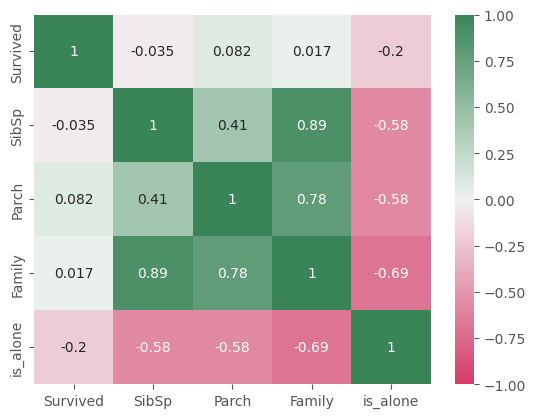

In [14]:
# Добавим признак is_alone
is_alone = []
for fam in df.Family:
    if fam == 0:
        is_alone.append(1)
    else:
        is_alone.append(0)
df.insert(14, 'is_alone', is_alone)

# Correlation heatmap
sns.heatmap(df[['Survived', 'SibSp', 'Parch', 'Family', 'is_alone']].corr(), annot=True, vmin=-1, vmax=1, cmap=sns.diverging_palette(0, 500, as_cmap=True))

<Axes: >

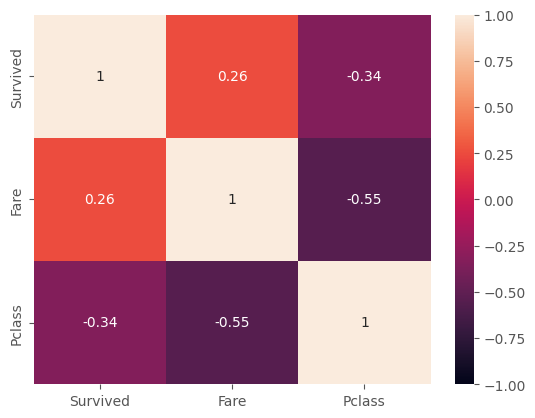

In [15]:
sns.heatmap(df[['Survived', 'Fare', 'Pclass']].corr(), annot=True, vmin=-1, vmax=1)

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\164739521.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(fare.values(), labels=(1,2,3), vert=True)


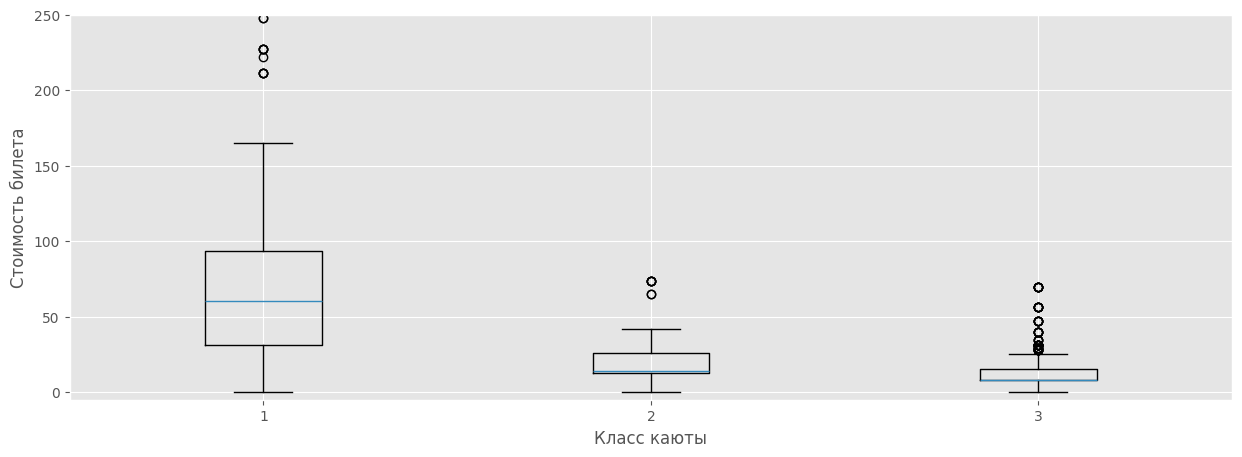

In [16]:
fare = dict.fromkeys((1,2,3), [])
for i, price in enumerate(df.Fare):
    fare[df.Pclass[i]] = fare[df.Pclass[i]] + [price]


fig, ax = plt.subplots(figsize=(15,5))
ax.boxplot(fare.values(), labels=(1,2,3), vert=True)
ax.set_ylabel('Стоимость билета')
ax.set_xlabel('Класс каюты')
ax.set_ylim(-5, 250)
plt.show()

In [26]:
for i, fare in enumerate(df.Fare):
    if np.isclose(fare, .0):
        df.Fare[i] = np.median([df.Pclass[i]])

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\224067145.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Fare[i] = np.median([df.Pclass[i]])
C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\224067145.py:3: Se

In [27]:
for i, emb in enumerate(df.Embarked):
    if pd.isna(emb): df.Embarked[i] = 'S'

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\2238888376.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  if pd.isna(emb): df.Embarked[i] = 'S'
C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\2238888376.py:2: S

In [44]:
TITLES = ("Capt.","Col.","Major.","Sir.","Lady.","Rev.","Dr.","Don.","Jonkheer.","Countess.","Mrs.","Ms.","Mr.","Mme.","Mlle.","Miss.","Master.", "Dona.")
ARISTOCRATIC = ("Capt.", "Col.", "Don.", "Dr.",
                "Jonkheer.", "Lady.", "Major.",
                "Rev.", "Sir.", "Countess.", 'Dona')
MRS = ("Ms.")
MISS = ("Mlle.", 'Mme.')

for file in ('train', 'test'):

    # Считываем файл
    dataset = pd.read_csv(f'{file}.csv')

    # Кодируем пол
    dataset = dataset.replace({'female' : 1, 'male': 0})

    # Восстанавливаем стоимость билетов
    dataset.Fare.fillna(0, inplace = True)
    fares = dict.fromkeys((1,2,3), [])
    for i, price in enumerate(dataset.Fare):
        fares[dataset.Pclass[i]] = fares[dataset.Pclass[i]] + [price]
    for i, fare in enumerate(dataset.Fare):
        if np.isclose(fare, .0):
            dataset.loc[i, 'Fare'] = np.median(fares[dataset.Pclass[i]])

    #Создадим список титулов для каждого пассажира
    titled_names = []
    for name in dataset.loc[:, 'Name']:
        for title in TITLES:
            if title in name.split(' '):
                titled_names.append(title)
                break

    # Вставляем в датасет столбец Title
    dataset.insert(1, 'Title', titled_names)

    #Создадим словарь с парами "титул: список возрастов"
    ages = dict.fromkeys(TITLES, [])
    for i, title in enumerate(dataset.Title):
        if not pd.isna(dataset.Age[i]):
            ages[title] = ages[title] + [dataset.Age[i]]
            
    # Создаем признак Семья
    dataset['Family'] = dataset.Parch + dataset.SibSp

    # Кодируем бинарные признаки
    dataset['Is_Alone'] = dataset.Family == 0
    dataset['Have_Cabin'] = pd.notna(dataset.Cabin)
    dataset['Have_age'] = pd.notna(dataset.Age)
    dataset = dataset.replace({True: 1, False: 0})

    # Восстанавливаем пропущенные возраста
    for i, age in enumerate(dataset.loc[:, 'Age']):
        if pd.isna(age):
            dataset.loc[i, 'Age'] = np.median(ages[dataset.Title[i]])

    # Объединяем титулы
    for i, title in enumerate(dataset.Title):
        if title in ARISTOCRATIC:
            dataset.loc[i, 'Title'] = 'Aristocratic.'
        elif title in MISS:
            dataset.loc[i, 'Title'] = 'Miss.'
        elif title in MRS:
            dataset.loc[i, 'Title'] = 'Mrs.'

    # Восстанавливаем порт отправления
    dataset.Embarked.fillna(dataset.Embarked.mode()[0], inplace = True)

    # Кодируем порт и титулы
    dataset = dataset.join(pd.get_dummies(dataset.Embarked, prefix='Emb'))
    dataset = dataset.join(pd.get_dummies(dataset.Title, prefix='Title'))

    # Чистим от лишних столбцов
    dataset = dataset.drop(columns=['Ticket', 'Name', 'SibSp', 'Parch', 'Cabin', 'Title', 'Embarked'])  

    dataset.to_csv(f'clear_{file}.csv', index=False)

C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\3040707746.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.replace({'female' : 1, 'male': 0})
C:\Users\LeroIKudaibergen\AppData\Local\Temp\ipykernel_15756\3040707746.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<Axes: >

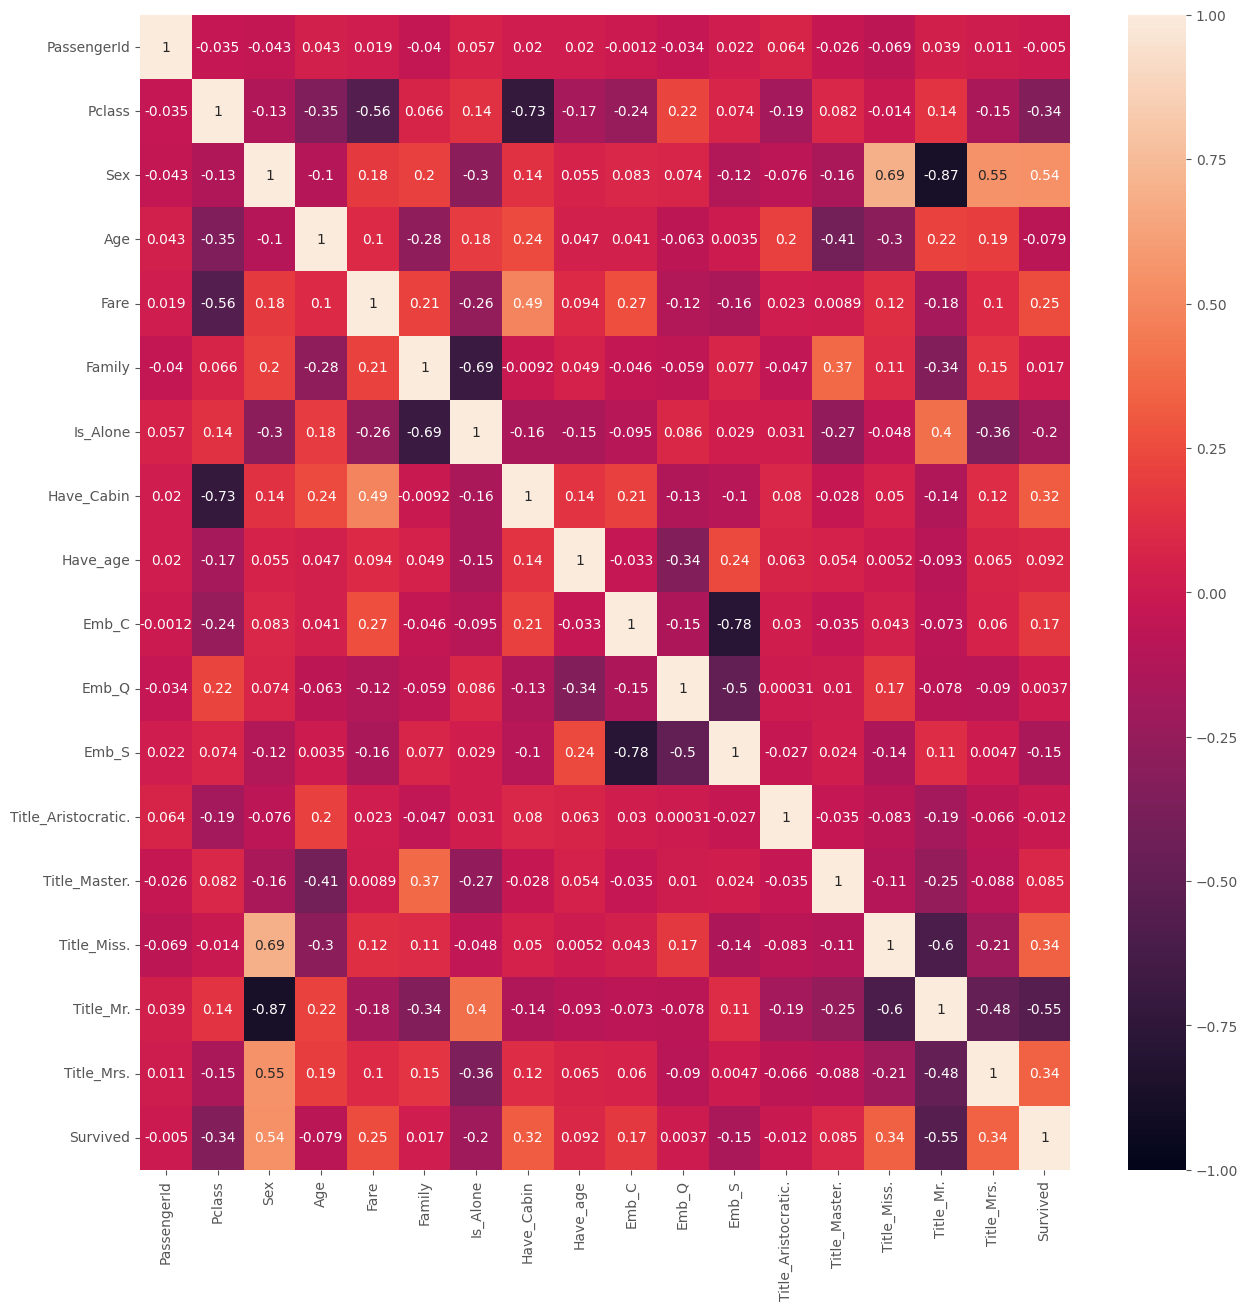

In [29]:
train_set = pd.read_csv('clear_train.csv')

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_set.corr(), annot=True, vmin=-1, vmax=1, ax=ax)

In [30]:
def normalize_data(train_vector: np.ndarray, test_vector: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    train_arr, test_arr = train_vector, test_vector
    united_arr = np.concatenate((train_arr, test_arr))

    mean = np.mean(united_arr, axis=0)
    std_deviation = np.std(united_arr, axis=0)

    train_X = (train_arr - mean) / std_deviation
    test_X = (test_arr - mean) / std_deviation

    return train_X, test_X

In [36]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer_1 = nn.Linear(16, 512)
        self.b_norm = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.layer_4 = nn.Linear(512, 2)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.b_norm(x)

        x = self.layer_2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer_3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer_4(x)
        x = F.softmax(x)

        return x

In [49]:
import configparser
import os
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import neptune

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

model = Net()
model.to(device)
model.type(torch.cuda.FloatTensor)

# Hyper Params
num_epochs = 2000
batch_size = 64
learning_rate = 1e-2
weight_decay = 1e-2
validation_split = .1

# Загрузка данных
data_train = TitanicDataset(normalize=True)
train_loader, val_loader = get_loaders(batch_size=batch_size, data_train=data_train, validation_split=validation_split)

# Loss Function, Optimizer
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# LR Annealing
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.6, patience=100)

config = configparser.ConfigParser()
config.read('config.ini')

run = neptune.init_run(
    project="pas-zhukov/Titanic-Kaggle",
    api_token=config['Config']['api_token'],
    source_files=['networks.py', 'learning.ipynb', 'metrics_functions.py', 'data_functions.py', 'learning.py']
)
params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'validation_split': validation_split,
    'optimizer': 'Adam',
    'annealing_factor': .6
}
run["parameters"] = params

loss_history = []
val_loss_history = []
train_history = []
val_history = []
lr_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()

    loss_accum = 0
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(train_loader):
        #run['train/batch/lr'].append(scheduler.optimizer.param_groups[0]['lr'])
        x = x.to(device)
        y = y.to(device)

        prediction = model(x)
        loss_value = loss(prediction, y)
        #run['train/batch/loss'].append(loss)
        optimizer.zero_grad()
        loss_value.backward()
        # Обновляем веса
        optimizer.step()

        # Определяем индексы, соответствующие выбранным моделью лейблам
        _, indices = torch.max(prediction, dim=1)
        # Сравниваем с ground truth, сохраняем количество правильных ответов
        correct_samples += torch.sum(indices == y)
        # Сохраняем количество всех предсказаний
        total_samples += y.shape[0]
        #run['train/batch/acc'].append(correct_samples / total_samples)

        loss_accum += loss_value

    # Среднее значение функции потерь за эпоху
    ave_loss = loss_accum / (i_step + 1)
    # Рассчитываем точность тренировочных данных на эпохе
    train_accuracy = float(correct_samples) / total_samples
    # Рассчитываем точность на валидационной выборке (вообще после этого надо бы гиперпараметры поподбирать...)
    val_accuracy = compute_binary_accuracy(model, val_loader)

    # Сохраняем значения ф-ии потерь и точности для последующего анализа и построения графиков
    loss_history.append(float(ave_loss))
    train_history.append(train_accuracy)
    val_history.append(val_accuracy)

    # Посчитаем лосс на валидационной выборке
    val_loss = validation_loss(model, val_loader, loss)
    val_loss_history.append(val_loss)

    run['train/epoch/loss'].append(ave_loss)
    run['valid/epoch/loss'].append(val_loss)
    run['train/epoch/acc'].append(train_accuracy)
    run['valid/epoch/acc'].append(val_accuracy)
    run['train/epoch/lr'].append(scheduler.optimizer.param_groups[0]['lr'])

    lr_history.append(scheduler.optimizer.param_groups[0]['lr'])
    # Уменьшаем лернинг рейт (annealing)
    scheduler.step(val_loss)

print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

test_set = TitanicDataset(test=True, normalize=True)
test_loader = DataLoader(test_set, batch_size=1)

predictions = []
labels = {}

for i_step, (x, y) in enumerate(test_loader):
    x = x.to(device)
    model.eval()
    prediction = model(x)
    predictions.append(torch.argmax(prediction, dim=1))
    labels[i_step + 892] = int(torch.argmax(prediction, dim=1))

output = pd.DataFrame(labels.items(), columns=['PassengerId', 'Survived'])
output.to_csv(os.path.join('outputs/output' + datetime.datetime.now().strftime('%d%m%y%H%M') + '.csv'), index=False)

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -INCLUDE:?warp_size@cuda@at@@YAHXZ in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using link on your binary to see if there is a dependency on *_cuda.dll library.